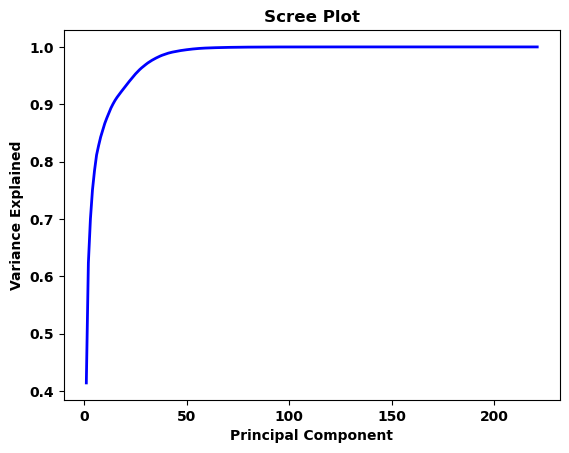

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from ltm.features import load_raster
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the dataset
X = load_raster("../data/processed/band_importance/X_sentinel.tif")
X_palsar = load_raster("../data/processed/band_importance/X_palsar.tif")
X = pd.concat([X, X_palsar], axis=1)

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Define PCA model to use
pca = PCA()
pca_fit = pca.fit(scaled_df)
PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [7]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
sum(cumsum < 0.99)

41